In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.

%matplotlib inline

from xgboost import XGBRegressor 
from xgboost import plot_importance, plot_tree

plt.style.use('fivethirtyeight')

In [89]:
path = r'C:\Users\maria\Desktop\Data Science\01_PROJETO_INTEGRADOR\HISTORICO_2.xlsx'
data = pd.read_excel(path, sheet_name = 'SQL Results',delimiter = ',')

In [90]:
data.head()

,DIA,VDA,CMV,MTA,DIA_SEMANA,TIPO_FERIADO,FERIADO_BOOL,maxtempC,mintempC,avgtempC,weatherDesc,precipMM
0,2018-01-01,0.00,0.00,0.00,2,Confraternização Universal,1,26,19,22,Light rain shower,1.6
1,2018-01-02,3114.43,2926.84,20332.44,3,0,0,24,20,22,Light rain shower,5.2
2,2018-01-03,3582.08,3532.96,21243.48,4,0,0,24,20,21,Light rain shower,6.3
3,2018-01-04,5450.85,5448.48,27684.14,5,0,0,27,18,22,Patchy rain possible,2.5
4,2018-01-05,9680.96,9478.50,56945.88,6,0,0,28,18,22,Partly cloudy,3.1


In [91]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VDA,577.0,8411.629255,5973.813375,0.0,4457.86,6739.93,10450.99,56959.83
CMV,577.0,7926.986343,5595.182936,0.0,4228.06,6344.26,9795.22,54024.84
MTA,577.0,42246.538419,29459.281756,0.0,21384.97,34669.35,56149.46,176368.77
DIA_SEMANA,577.0,3.994801,1.998691,1.0,2.00,4.00,6.00,7.00
FERIADO_BOOL,577.0,0.032929,0.178605,0.0,0.00,0.00,0.00,1.00
maxtempC,577.0,26.136915,2.801346,15.0,25.00,26.00,28.00,34.00
mintempC,577.0,16.679376,2.867952,5.0,15.00,17.00,19.00,22.00
avgtempC,577.0,21.344887,2.745061,12.0,20.00,21.00,23.00,29.00
precipMM,577.0,5.129809,8.937482,0.0,0.00,1.20,6.60,75.90


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 12 columns):
DIA             577 non-null datetime64[ns]
VDA             577 non-null float64
CMV             577 non-null float64
MTA             577 non-null float64
DIA_SEMANA      577 non-null int64
TIPO_FERIADO    577 non-null object
FERIADO_BOOL    577 non-null int64
maxtempC        577 non-null int64
mintempC        577 non-null int64
avgtempC        577 non-null int64
weatherDesc     577 non-null object
precipMM        577 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 54.2+ KB


(array([214., 235.,  75.,  43.,   6.,   2.,   0.,   0.,   0.,   2.]),
 array([    0.   ,  5695.983, 11391.966, 17087.949, 22783.932, 28479.915,
        34175.898, 39871.881, 45567.864, 51263.847, 56959.83 ]),
 <a list of 10 Patch objects>)

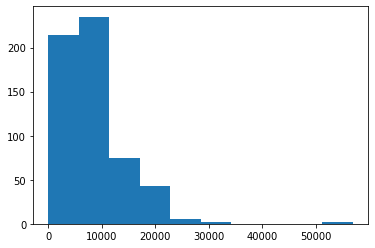

In [93]:
plt.hist(data.VDA)

Text(0, 0.5, 'Date')

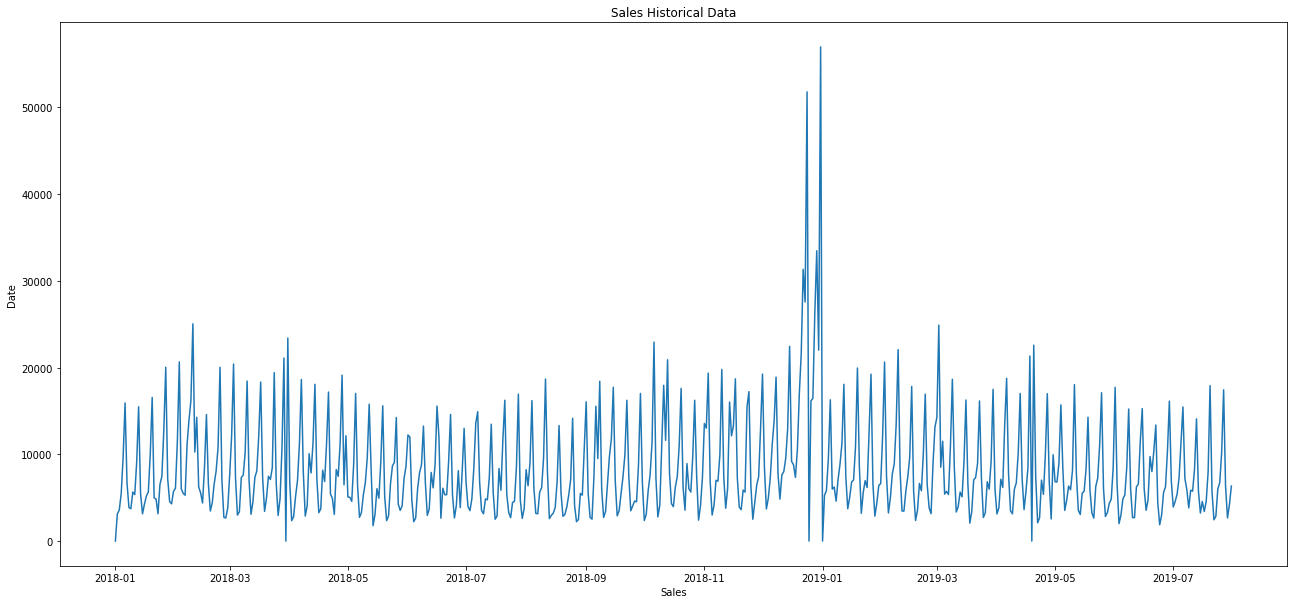

In [94]:
plt.figure(figsize=(22,10))
plt.plot(data.DIA, data.VDA)
plt.title("Sales Historical Data")
plt.xlabel("Sales")
plt.ylabel("Date")

In [95]:
def prepare_dataset(df):

    df['ds'] = df['DIA'] 
    df['y'] = df['VDA'] 
    
    df = pd.concat([df, pd.get_dummies(df['DIA_SEMANA'])], axis =1)
    
    
    return df

def lag(df):
    
    for i in range(1, 32):
        df["lag_{}".format(i)] = df.y.shift(i)
    
    return df

def add_date_params(df):
    
    df.index = pd.to_datetime(df.index)
    df["weekday"] = df.index.weekday
    df['is_weekend'] = df.weekday.isin([5,6])*1
    df.drop(['weekday'], axis = 1, inplace=True)
    return df


def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test




In [96]:
df = data.copy()
df['ds'] = df['DIA']
df['sales'] = df['VDA']
df.index = df['ds']
df = pd.concat([df, pd.get_dummies(df['DIA_SEMANA'])], axis =1)
df = pd.concat([df, pd.get_dummies(df['weatherDesc'])], axis =1)
df.head()

,DIA,VDA,CMV,MTA,DIA_SEMANA,TIPO_FERIADO,FERIADO_BOOL,maxtempC,mintempC,avgtempC,...,Moderate rain,Overcast,Partly cloudy,Patchy light drizzle,Patchy light rain,Patchy light rain with thunder,Patchy rain possible,Sunny,Thundery outbreaks possible,Torrential rain shower
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,0.00,0.00,0.00,2,Confraternização Universal,1,26,19,22,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,2018-01-02,3114.43,2926.84,20332.44,3,0,0,24,20,22,...,0,0,0,0,0,0,0,0,0,0
2018-01-03,2018-01-03,3582.08,3532.96,21243.48,4,0,0,24,20,21,...,0,0,0,0,0,0,0,0,0,0
2018-01-04,2018-01-04,5450.85,5448.48,27684.14,5,0,0,27,18,22,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,2018-01-05,9680.96,9478.50,56945.88,6,0,0,28,18,22,...,0,0,1,0,0,0,0,0,0,0


In [97]:
df = df.drop(columns=['CMV', 'DIA', 'MTA', 'DIA_SEMANA', 'TIPO_FERIADO', 'FERIADO_BOOL', 'VDA', 'ds', 'weatherDesc'])
df.head()

,maxtempC,mintempC,avgtempC,precipMM,sales,1,2,3,4,5,...,Moderate rain,Overcast,Partly cloudy,Patchy light drizzle,Patchy light rain,Patchy light rain with thunder,Patchy rain possible,Sunny,Thundery outbreaks possible,Torrential rain shower
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,26,19,22,1.6,0.00,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,24,20,22,5.2,3114.43,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-03,24,20,21,6.3,3582.08,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-04,27,18,22,2.5,5450.85,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,28,18,22,3.1,9680.96,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [98]:
for i in range(1, 29):
    
    df["lag_{}".format(i)] = df['sales'].shift(i) 

In [99]:
df.tail()

,maxtempC,mintempC,avgtempC,precipMM,sales,1,2,3,4,5,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
ds,,,,,,,,,,,,,,,,,,,,,
2019-07-27,27,14,22,0.0,17433.34,0,0,0,0,0,...,5952.61,7227.85,15461.38,11473.18,7293.47,5421.70,4576.78,3927.31,6936.46,16137.01
2019-07-28,27,13,21,0.0,6299.95,1,0,0,0,0,...,3832.59,5952.61,7227.85,15461.38,11473.18,7293.47,5421.70,4576.78,3927.31,6936.46
2019-07-29,25,13,20,0.0,2664.87,0,1,0,0,0,...,5869.13,3832.59,5952.61,7227.85,15461.38,11473.18,7293.47,5421.70,4576.78,3927.31
2019-07-30,26,15,21,0.9,4209.87,0,0,1,0,0,...,5755.21,5869.13,3832.59,5952.61,7227.85,15461.38,11473.18,7293.47,5421.70,4576.78
2019-07-31,26,14,21,0.0,6348.06,0,0,0,1,0,...,8361.71,5755.21,5869.13,3832.59,5952.61,7227.85,15461.38,11473.18,7293.47,5421.70


In [102]:
df.shape, df.columns

((577, 57),
 Index([                      'maxtempC',                       'mintempC',
                              'avgtempC',                       'precipMM',
                                 'sales',                                1,
                                       2,                                3,
                                       4,                                5,
                                       6,                                7,
                                'Cloudy',                            'Fog',
                            'Heavy rain',                  'Light drizzle',
                     'Light rain shower',                           'Mist',
         'Moderate or heavy rain shower',                  'Moderate rain',
                              'Overcast',                  'Partly cloudy',
                  'Patchy light drizzle',              'Patchy light rain',
        'Patchy light rain with thunder',           'Patchy rain possible',


In [105]:
df.dropna(inplace=True, axis=0)
df.head()

,maxtempC,mintempC,avgtempC,precipMM,sales,1,2,3,4,5,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-29,27,19,23,13.5,4552.95,0,1,0,0,0,...,5652.97,3725.39,3869.68,6719.00,15922.53,9680.96,5450.85,3582.08,3114.43,0.00
2018-01-30,26,19,22,3.8,4293.03,0,0,1,0,0,...,5356.88,5652.97,3725.39,3869.68,6719.00,15922.53,9680.96,5450.85,3582.08,3114.43
2018-01-31,27,16,21,0.0,5732.61,0,0,0,1,0,...,9084.72,5356.88,5652.97,3725.39,3869.68,6719.00,15922.53,9680.96,5450.85,3582.08
2018-02-01,27,15,21,0.0,6084.10,0,0,0,0,1,...,15483.65,9084.72,5356.88,5652.97,3725.39,3869.68,6719.00,15922.53,9680.96,5450.85
2018-02-02,27,18,22,1.0,11514.50,0,0,0,0,0,...,5477.86,15483.65,9084.72,5356.88,5652.97,3725.39,3869.68,6719.00,15922.53,9680.96


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1642 entries, 2015-01-30 to 2019-07-31
Data columns (total 36 columns):
sales     1642 non-null float64
1         1642 non-null uint8
2         1642 non-null uint8
3         1642 non-null uint8
4         1642 non-null uint8
5         1642 non-null uint8
6         1642 non-null uint8
7         1642 non-null uint8
lag_1     1642 non-null float64
lag_2     1642 non-null float64
lag_3     1642 non-null float64
lag_4     1642 non-null float64
lag_5     1642 non-null float64
lag_6     1642 non-null float64
lag_7     1642 non-null float64
lag_8     1642 non-null float64
lag_9     1642 non-null float64
lag_10    1642 non-null float64
lag_11    1642 non-null float64
lag_12    1642 non-null float64
lag_13    1642 non-null float64
lag_14    1642 non-null float64
lag_15    1642 non-null float64
lag_16    1642 non-null float64
lag_17    1642 non-null float64
lag_18    1642 non-null float64
lag_19    1642 non-null float64
lag_20    1642 non-null f

In [104]:
df.columns

Index([                      'maxtempC',                       'mintempC',
                             'avgtempC',                       'precipMM',
                                'sales',                                1,
                                      2,                                3,
                                      4,                                5,
                                      6,                                7,
                               'Cloudy',                            'Fog',
                           'Heavy rain',                  'Light drizzle',
                    'Light rain shower',                           'Mist',
        'Moderate or heavy rain shower',                  'Moderate rain',
                             'Overcast',                  'Partly cloudy',
                 'Patchy light drizzle',              'Patchy light rain',
       'Patchy light rain with thunder',           'Patchy rain possible',
                         

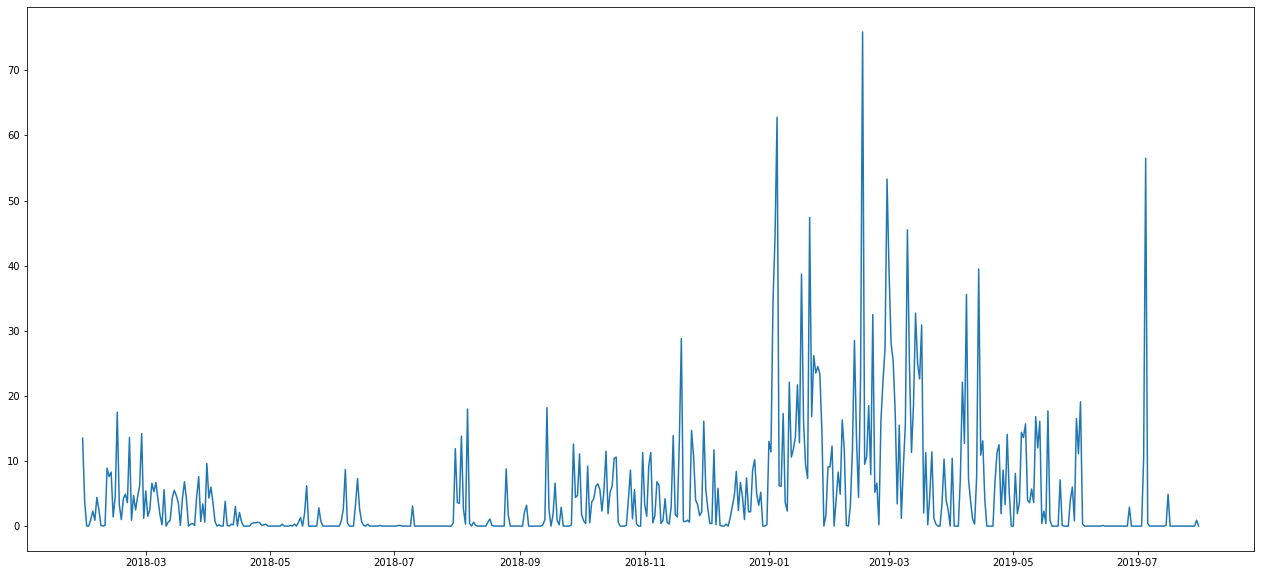

In [107]:
plt.figure(figsize=(22,10))
plt.plot(df.index, df.precipMM)

In [123]:
split_date = '2019-04-11'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()



In [124]:
df_train.shape, df_test.shape

((438, 57), (111, 57))

In [137]:
colunas = list(df.drop(columns='sales').columns)
colunas

['maxtempC',
 'mintempC',
 'avgtempC',
 'precipMM',
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 'Cloudy',
 'Fog',
 'Heavy rain',
 'Light drizzle',
 'Light rain shower',
 'Mist',
 'Moderate or heavy rain shower',
 'Moderate rain',
 'Overcast',
 'Partly cloudy',
 'Patchy light drizzle',
 'Patchy light rain',
 'Patchy light rain with thunder',
 'Patchy rain possible',
 'Sunny',
 'Thundery outbreaks possible',
 'Torrential rain shower',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28']

In [138]:
X_train, y_train = df_train[colunas], df_train['sales']
X_test, y_test = df_test[colunas], df_test['sales']

In [144]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[23:46:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

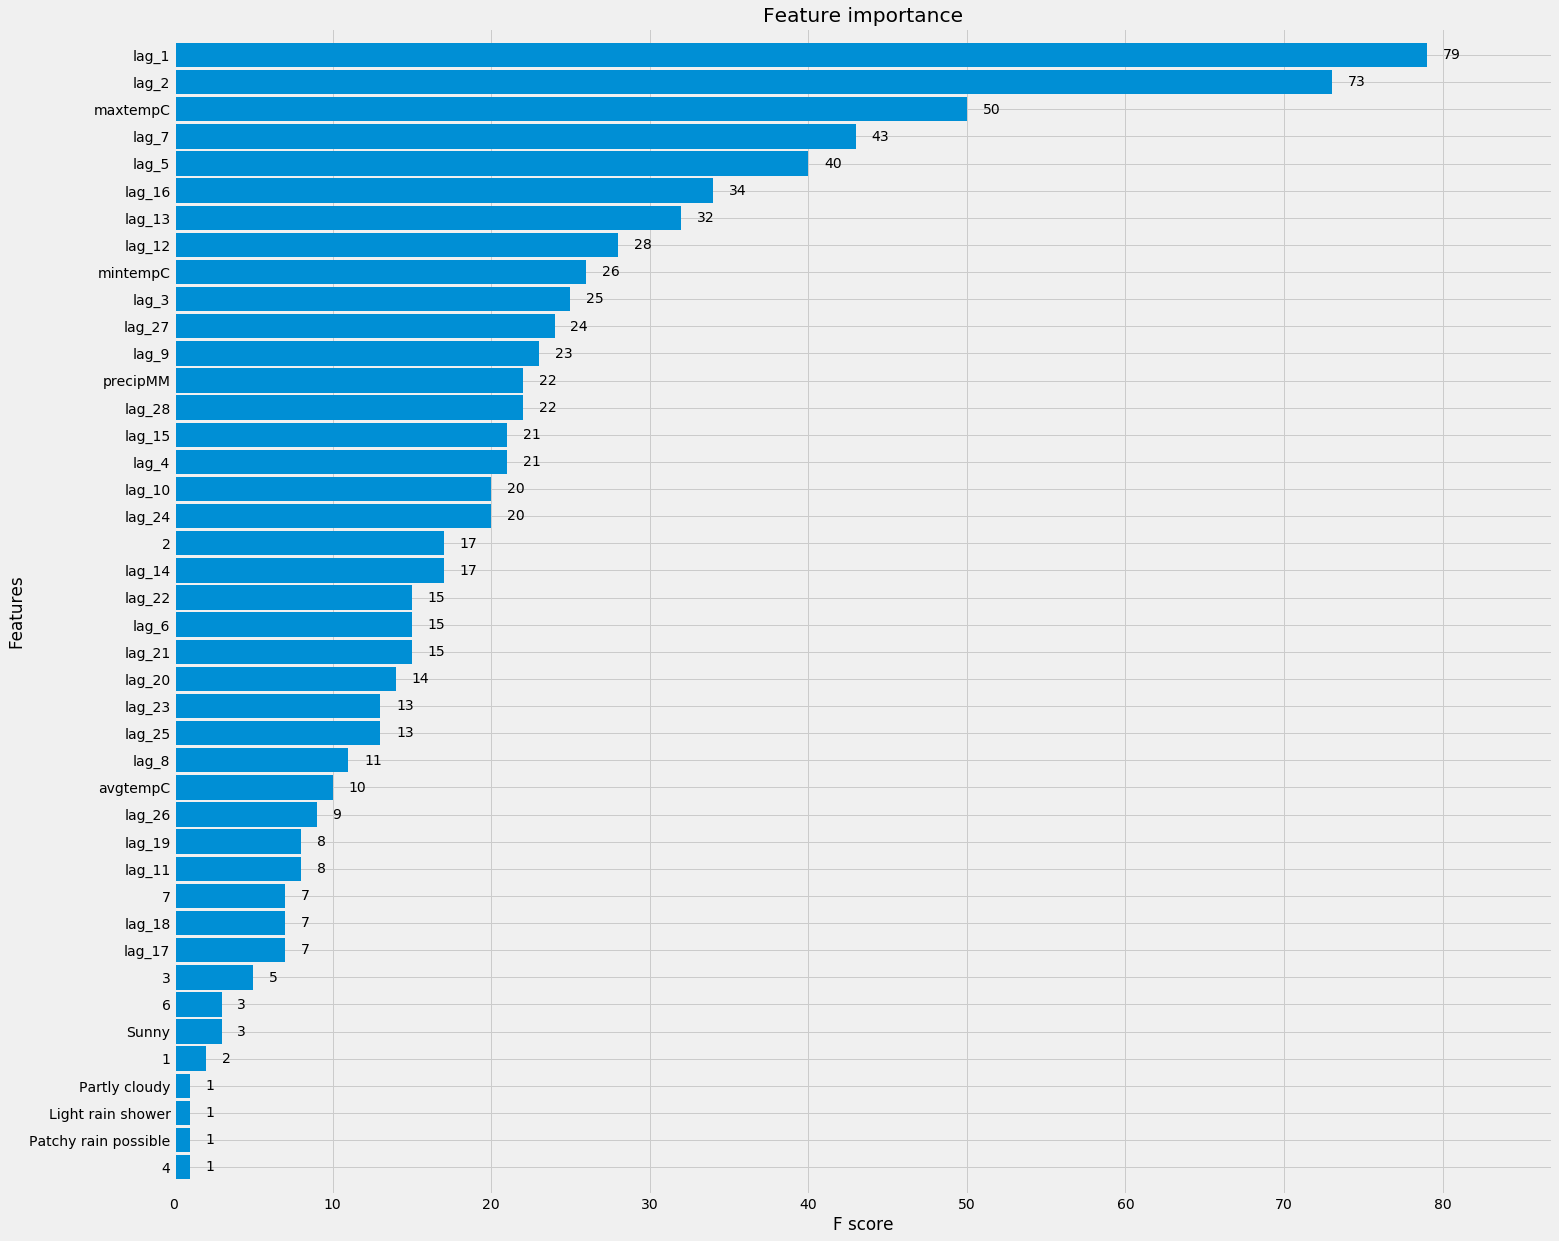

In [160]:
fig, ax = plt.subplots(1,1,figsize=(22,20))
_ = plot_importance(xgb, ax = ax, height=0.9)

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
xgb_scaled = XGBRegressor(n_estimators=1000)
xgb_scaled.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[23:53:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

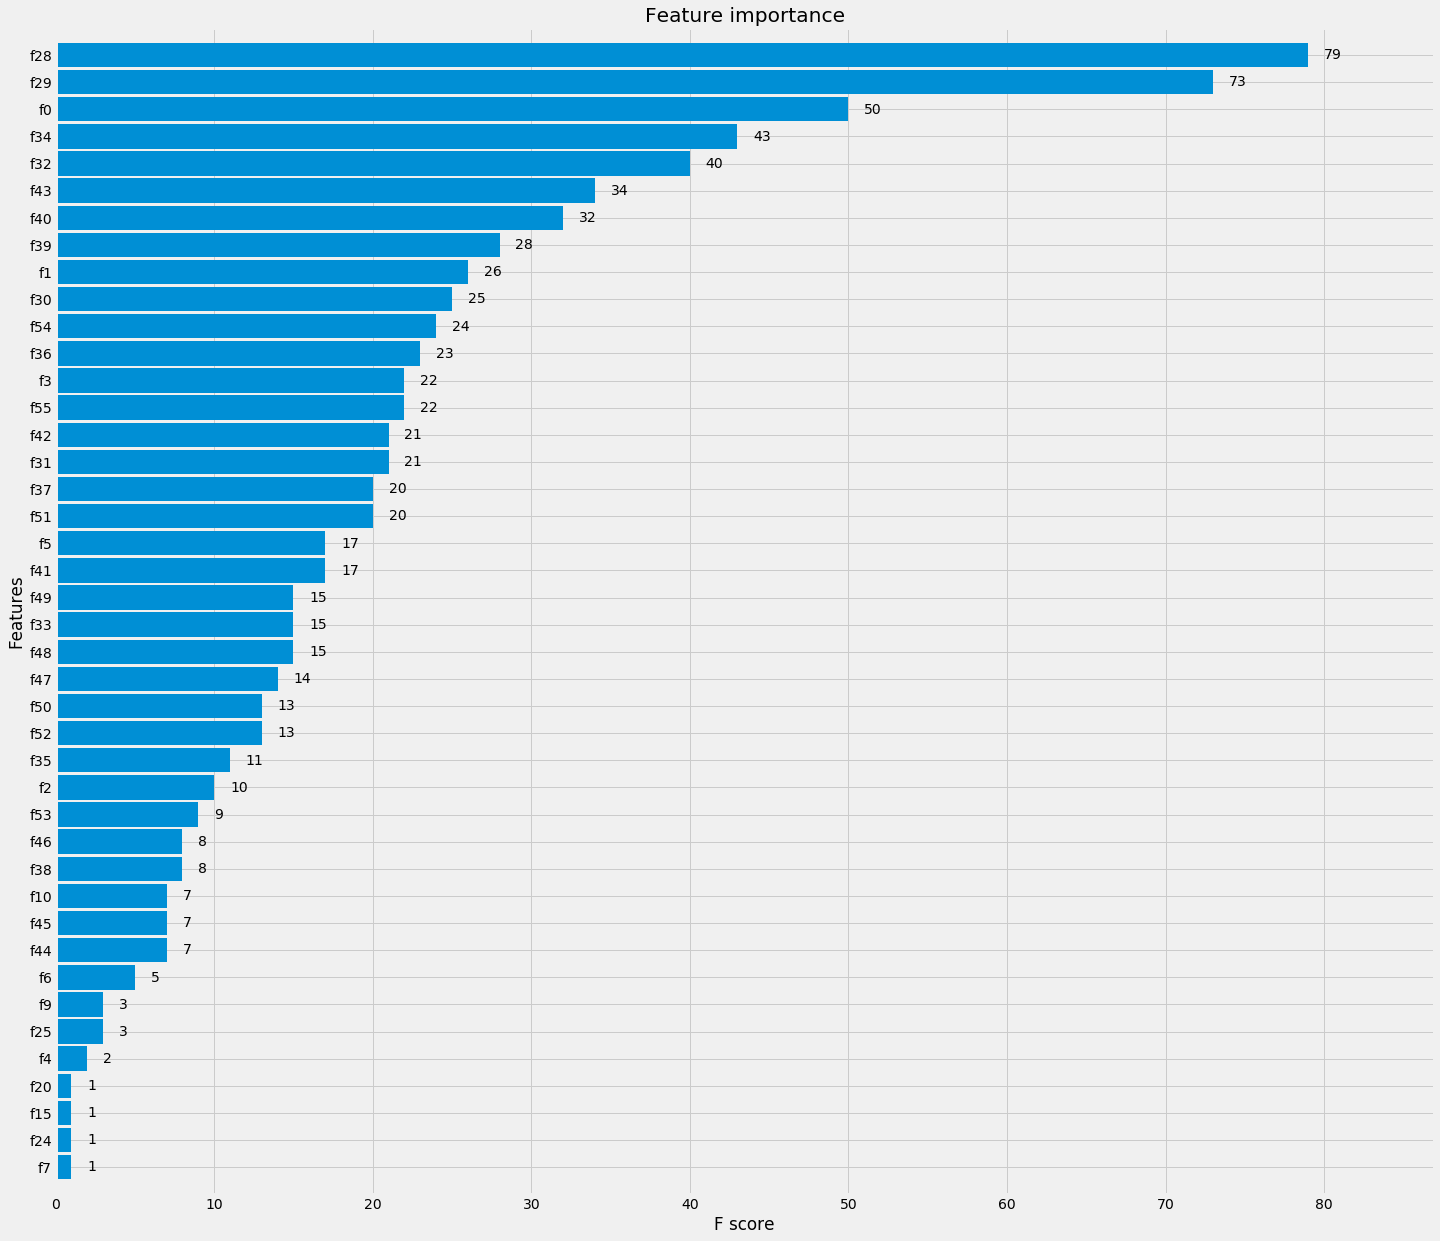

In [164]:
fig, ax = plt.subplots(1,1,figsize=(22,20))
_ = plot_importance(xgb_scaled, ax = ax, height=0.9)

In [179]:
ajuda = list(range(0,len(df.columns)))
w = pd.DataFrame({'Index': ajuda, 'Colunas': df.columns})

In [180]:
w

,Index,Colunas
0,0,maxtempC
1,1,mintempC
2,2,avgtempC
3,3,precipMM
4,4,sales
5,5,1
6,6,2
7,7,3
8,8,4
9,9,5


In [184]:
df_test['Prediction'] = xgb.predict(X_test_scaled)
df_all = pd.concat([df_test, df_train], sort=False)

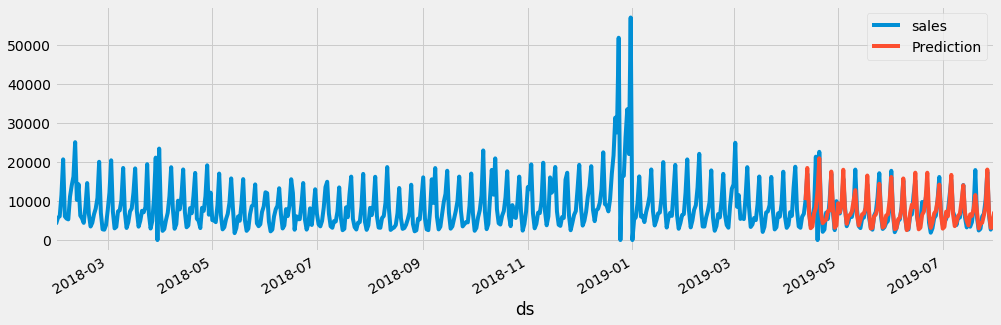

In [185]:
_ = df_all[['sales','Prediction']].plot(figsize=(15, 5))

In [187]:
mean_squared_error(y_true=df_test['sales'],
                   y_pred=df_test['Prediction'])

5959681.612053142

In [188]:
mean_absolute_error(y_true=df_test['sales'],
                   y_pred=df_test['Prediction'])

1517.871514815597

In [191]:
y_true=df_test['sales']
y_pred=df_test['Prediction']
y_true, y_pred = np.array(y_true), np.array(y_pred)
np.mean(np.abs((y_true - y_pred) / y_true)) * 100

inf

In [198]:
thundery = data.loc[(data['weatherDesc'] == 'Thundery outbreaks possible'),:]

In [199]:
thundery.head()

,DIA,VDA,CMV,MTA,DIA_SEMANA,TIPO_FERIADO,FERIADO_BOOL,maxtempC,mintempC,avgtempC,weatherDesc,precipMM
160,2018-06-10,6688.43,6348.26,0.00,1,0,0,27,16,21,Thundery outbreaks possible,0.0
228,2018-08-17,6857.05,6117.69,42950.45,6,0,0,22,13,17,Thundery outbreaks possible,1.1
303,2018-10-31,7318.49,6848.06,53593.43,4,0,0,30,19,24,Thundery outbreaks possible,11.3
397,2019-02-02,20639.28,19019.30,105044.17,7,0,0,32,22,28,Thundery outbreaks possible,0.0
415,2019-02-20,6644.79,6107.43,27446.12,4,0,0,29,19,25,Thundery outbreaks possible,7.9


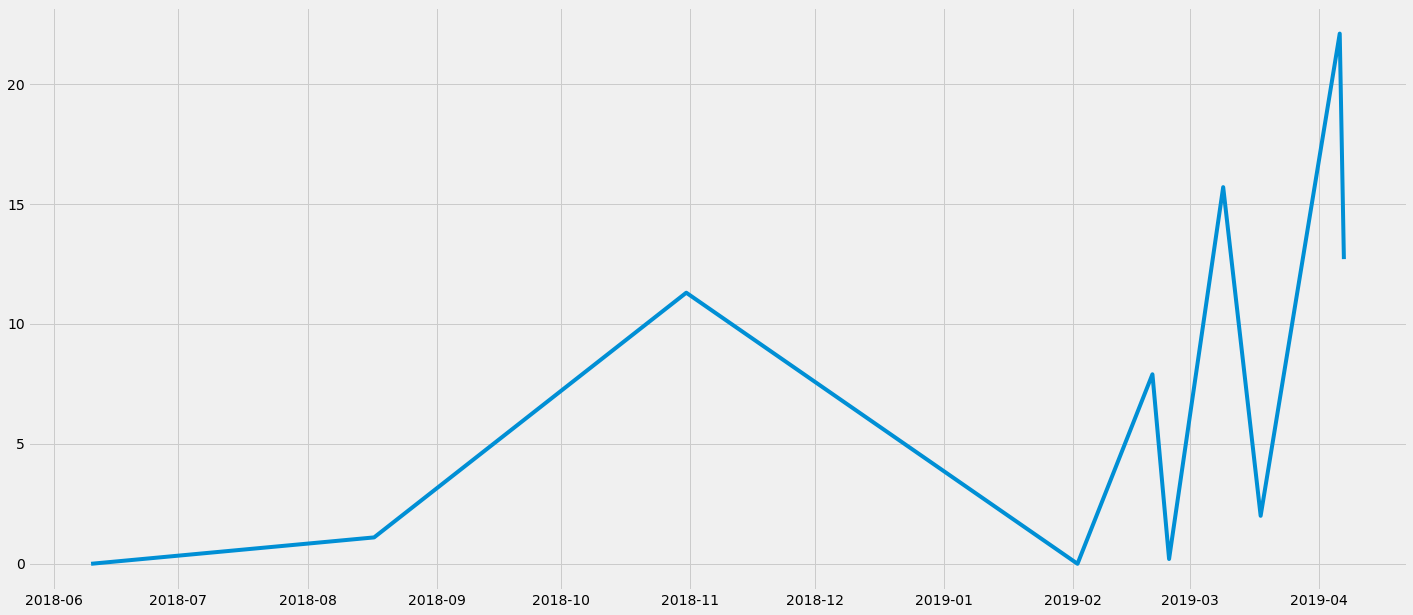

In [200]:
plt.figure(figsize=(22,10))
plt.plot(thundery.DIA, thundery.precipMM)

In [203]:
np.mean(thundery.precipMM)

7.3

In [ ]:
np.mean(thundery.precipMM)

In [201]:
torrential = data.loc[(data['weatherDesc'] == 'Torrential rain shower'),:]

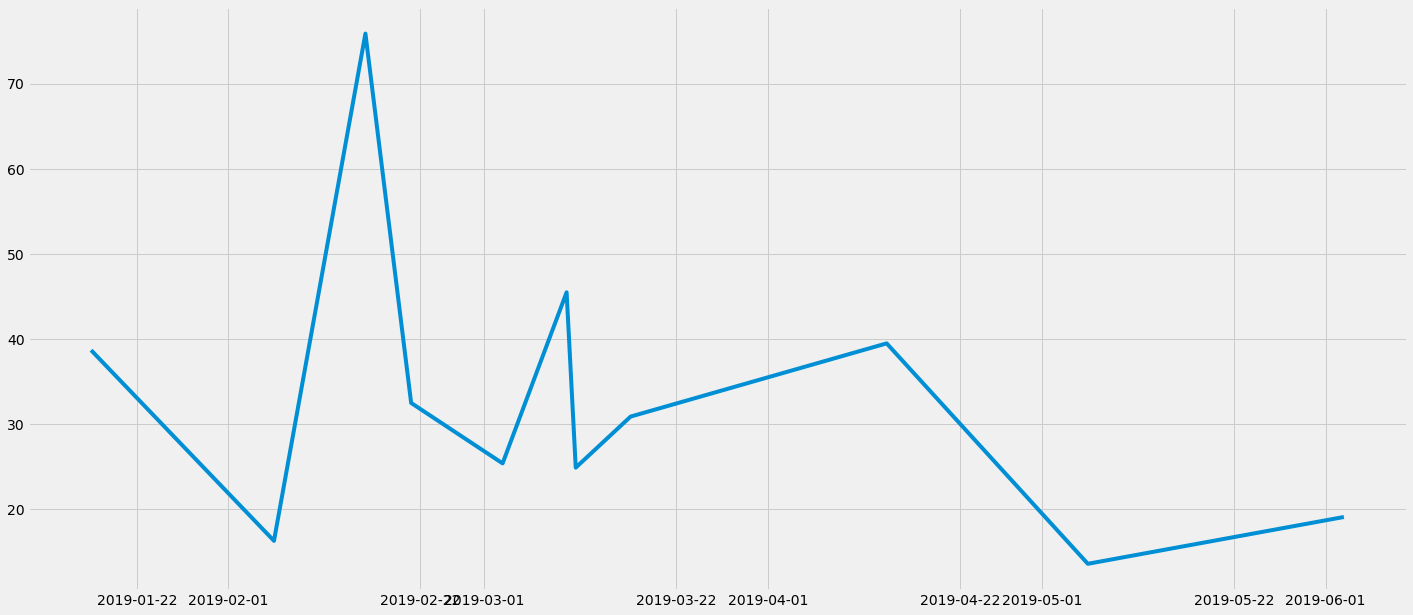

In [202]:
plt.figure(figsize=(22,10))
plt.plot(torrential.DIA, torrential.precipMM)

In [206]:
np.mean(torrential.precipMM)


32.93636363636364

In [207]:
np.std(torrential.precipMM)

16.645625836961862